Multiple overlapping images of the same scene, combined into a single image, can yield amazing results. 

This tutorial will illustrate how to accomplish panorama stitching opencv and scikit image, 

from loading the images to cleverly stitching them together.

In [1]:
import numpy as np
import cv2
import math
from skimage.morphology import closing,square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.graph import route_through_array
from matplotlib import pyplot as plt
from skimage.color import gray2rgb
from skimage.feature import plot_matches
print(cv2.__version__)

3.3.0


In [2]:
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

In [3]:
import skimage.io as io

pano_imgs = io.ImageCollection('jpg/*.jpg')

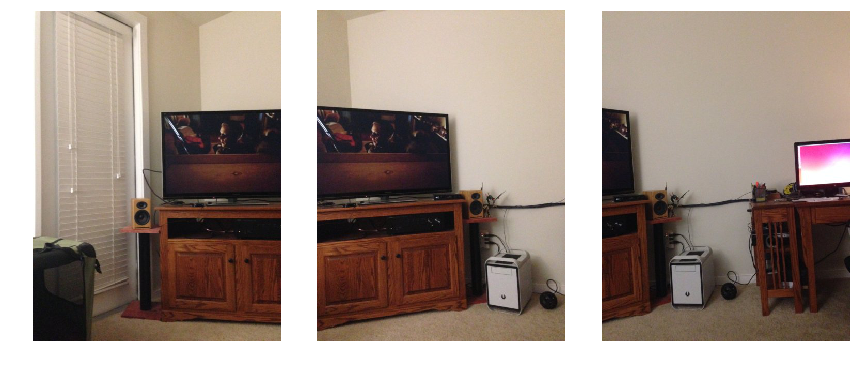

In [4]:
compare(*pano_imgs, figsize=(12, 10))

We are defining few utility function's to compare multiple images

In [5]:
# KeyPoint Matching Function
def filter_matches(matches, ratio = 0.75):
    filtered_matches = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            filtered_matches.append(m[0])
    return filtered_matches

In [6]:
def imageDistance(matches):
    sumDistance = 0.0
    for match in matches:
        sumDistance += match.distance
    return sumDistance

In [7]:
#finding Dimensions of new Image
def findDimensions(image, homography):
    base_p1 = np.ones(3, np.float32)
    base_p2 = np.ones(3, np.float32)
    base_p3 = np.ones(3, np.float32)
    base_p4 = np.ones(3, np.float32)

    (y, x) = image.shape[:2]

    base_p1[:2] = [0,0]
    base_p2[:2] = [x,0]
    base_p3[:2] = [0,y]
    base_p4[:2] = [x,y]

    max_x = None
    max_y = None
    min_x = None
    min_y = None

    for pt in [base_p1, base_p2, base_p3, base_p4]:

        hp = np.matrix(homography, np.float32) * np.matrix(pt, np.float32).T

        hp_arr = np.array(hp, np.float32)

        normal_pt = np.array([hp_arr[0]/hp_arr[2], hp_arr[1]/hp_arr[2]], np.float32)

        if ( max_x == None or normal_pt[0,0] > max_x ):
            max_x = normal_pt[0,0]

        if ( max_y == None or normal_pt[1,0] > max_y ):
            max_y = normal_pt[1,0]

        if ( min_x == None or normal_pt[0,0] < min_x ):
            min_x = normal_pt[0,0]

        if ( min_y == None or normal_pt[1,0] < min_y ):
            min_y = normal_pt[1,0]

    min_x = min(0, min_x)
    min_y = min(0, min_y)

    return (min_x-5, min_y-5, max_x+5, max_y+5)

In [8]:
def get_feature(img):
    # Initiate FAST detector
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(img, None)
    return kps, features

In [9]:
#getting fetures and using KNNbased Macher
def find_matches_and_get_homograpy(base_features,base_descs,next_descs,next_features):
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(next_descs,base_descs, k=2)

#     matcher = cv2.DescriptorMatcher_create("BruteForce")
#     matches = matcher.knnMatch(next_descs,base_descs, k=2)
    
    matches_subset = filter_matches(matches)

    distance = imageDistance(matches_subset)
    averagePointDistance = distance/float(len(matches_subset))
    kp1 = []
    kp2 = []

    for match in matches_subset:
        kp1.append(base_features[match.trainIdx])
        kp2.append(next_features[match.queryIdx])

    #p2 = np.array([[k[1]]+[k[0]] for k in kp1])
    #p1 = np.array([[k[1]]+[k[0]] for k in kp2])

    p2 = np.array([[k.pt[0]]+[k.pt[1]] for k in kp1])
    p1 = np.array([[k.pt[0]]+[k.pt[1]] for k in kp2])

    try:
        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
        #H[0:2,0:3] = cv2.estimateRigidTransform(p1,p2,False)       
        
        return H,1
    except Exception as e:
        print('homo',e)
        return None,None

In [10]:
def generate_costs_minimum_cut(diff_image, mask ):
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image) *255    
    
    # Finally, place the difference image
    cost = costs_arr * (1-mask)+ diff_image * mask    
    return cost

In [11]:
def no_of_regions(extra_data_from_next_img):
    bw = closing(extra_data_from_next_img > 0, square(3))
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    # label image regions
    label_image = label(cleared)    
    region_bounding_boxes = []
    region_area = []
    
    i=1
    for region in regionprops(label_image):        
        #if region.area >= 100:
        i=i+1
        region_bounding_boxes.append(region.bbox)
        region_area.append(region.area)
    return i , region_bounding_boxes ,region_area

In [12]:
import os
def distance(listofpoint,point):
    dist = [20000]
    for p in listofpoint:
        dist.append(np.sqrt(np.square(p[0]-point[0])+np.square(p[1]-point[1])))
    return min(dist)
    

def find_intersection_points(basemask,mask_next):
    points= []
    for i in range(1,basemask.shape[0]-1):
        for j in range(1,basemask.shape[1]-1):
            mask_base_crop = basemask[i-1:i+2,j-1:j+2]>0
            mask_next_crop = mask_next[i-1:i+2,j-1:j+2]>0
            if (mask_base_crop ==0).any() and (mask_base_crop !=0).any() and (mask_next_crop ==0).any() and (mask_next_crop !=0).any():
                nearest_point_dist = distance(points,(i,j))
                if nearest_point_dist > 10:
                    points.append((i,j))
    return points

def find_intersection_points2(imedge):
    points= []
    for i in range(1,imedge.shape[0]-1):
        for j in range(1,imedge.shape[1]-1):            
            mask_next_crop = imedge[i-1:i+2,j-1:j+2] == 255
            if np.sum(mask_next_crop)==2 and mask_next_crop[1,1]:
                nearest_point_dist = distance(points,(i,j))
                if nearest_point_dist > 10:
                    points.append((i,j))
    return points

In [13]:
def get_division_mask(cost,mask_base,mask_next,box,overlap):
    # Convert list of lists to 2d coordinate array for easier indexing 
    
    mask = np.zeros_like(mask_base)
    edge = np.zeros_like(mask_base)
    
    (_,cnts, _) = cv2.findContours(mask_next.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
 
    # loop over the contours
    for c in cnts:
        # draw the contour and show it
        edge = cv2.drawContours(edge, [c], -1, (255), 1)  
    #edge = cv2.Canny(mask_next,0,255)    
    edge = cv2.bitwise_and(cv2.bitwise_not(mask_base),edge) 
    
    cv2.imwrite("mask_base.jpg",mask_base)
    
    edge  = (edge > 0)*255  
    
    mask[max(box[0]-3,0):min(box[2]+3,mask_base.shape[0]), max(box[1]-3,0):min(box[3]+3,mask_base.shape[0])] = edge[max(box[0]-3,0):min(box[2]+3,mask_base.shape[0]),
                                                                                                                    max(box[1]-3,0):min(box[3]+3,mask_base.shape[0])]
    
    #points = find_intersection_points(mask_base,mask_next)
    points = find_intersection_points2(mask) 
    cost_ = cost
    pts, _ = route_through_array(cost_, [points[0][0],points[0][1]], [points[1][0],points[1][1]], fully_connected=True)
        
    # Start with an array of zeros and place the path
    pts= np.array(pts)
    mask[pts[:, 0], pts[:, 1]] = 255  

    mask = (label(mask, connectivity=1, background=-1) == 1) 
    
    return mask

In [14]:
import os
dirlist = os.listdir('jpg/')

In [15]:
resize = 0
resizeratio = 1
blurr = 0
blurrKernelSize = 1

In [16]:
base_image_path = dirlist[0]
base_img_rgb = cv2.imread('jpg/'+base_image_path)

next_image_path = dirlist[1]

In [17]:
next_img_rgb = cv2.imread('jpg/'+next_image_path)
if resize==1:
    next_img_rgb = cv2.resize(next_img_rgb, (0,0), fx=resizeratio, fy=resizeratio) 

base_img = cv2.cvtColor(base_img_rgb,cv2.COLOR_BGR2GRAY)
next_img = cv2.cvtColor(next_img_rgb,cv2.COLOR_BGR2GRAY)

if blurr==1:
    next_img = cv2.GaussianBlur(next_img, (blurrKernelSize,blurrKernelSize), 0)
    base_img = cv2.GaussianBlur(base_img, (blurrKernelSize,blurrKernelSize), 0)

We need to estimate a transformation that relates the images together. The steps will be

    Define one image as a base Image, which will remain anchored while the others are warped
    Detect features in all  images
    Match features from images against the features in the center, anchored image.

In this three-shot series, the middle image pano1 is the logical anchor point.

We detect "SIFT"  features in both images.

In [18]:
base_features, base_descs = get_feature(base_img)
next_features, next_descs = get_feature(next_img) 

In [19]:
H,status = find_matches_and_get_homograpy(base_features,base_descs,next_descs,next_features)

In [20]:
(min_x, min_y, max_x, max_y) = findDimensions(next_img_rgb, H)
max_x = max(max_x, base_img.shape[1])
max_y = max(max_y, base_img.shape[0])
move_h = np.matrix(np.identity(3), np.float32)

In [21]:
if ( min_x < 0 ):
    move_h[0,2] += -min_x
    max_x += -min_x

if ( min_y < 0 ):
    move_h[1,2] += -min_y
    max_y += -min_y      

In [22]:
mod_inv_h = move_h * H

img_w = int(math.ceil(max_x))
img_h = int(math.ceil(max_y))

In [23]:
base_img_warp = cv2.warpPerspective(base_img_rgb,np.matrix(move_h, np.float32) , (img_w, img_h))
next_img_warp = cv2.warpPerspective(next_img_rgb, mod_inv_h, (img_w, img_h))
ret, mask_base = cv2.threshold(cv2.cvtColor(base_img_warp,cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY) 
ret, mask_next = cv2.threshold(cv2.cvtColor(next_img_warp,cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)

In [24]:
extra_data_from_next_img = cv2.bitwise_and(mask_next,cv2.bitwise_not(cv2.bitwise_and(mask_next,mask_base)))    
count,boundingboxes,area = no_of_regions(extra_data_from_next_img)       

/home/jitendra/anaconda3/envs/opencv/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/jitendra/anaconda3/envs/opencv/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


In [25]:
roi = cv2.bitwise_and(mask_next,mask_base)


we have defined cost for minimum cut algo:
    1. for overlapped region we have used diff as cost
    2. for non overlapping region we have defined high cost
    
Later we find point of intersection of two images 
we find minimum cost path from first point to the other point

In [26]:
cost = generate_costs_minimum_cut(np.abs(cv2.cvtColor(next_img_warp,cv2.COLOR_BGR2GRAY)-cv2.cvtColor(base_img_warp,cv2.COLOR_BGR2GRAY)),
                        roi/255)

In [27]:
for box in boundingboxes: 
    #mask0 = get_division_mask(cost, roi,mask_next/255, 0)
    mask0 = get_division_mask(cost, mask_base, mask_next,box, 0)

    pano_combined_1 = np.zeros_like(base_img_warp)

    # Place the masked portion of each image into the array
    # masks are 2d, they need to be (M, N, 3) to match the color images
    pano_combined_1 += base_img_warp * gray2rgb(mask0)
    pano_combined_1 += next_img_warp * gray2rgb(~mask0)

    base_img_warp_ = pano_combined_1

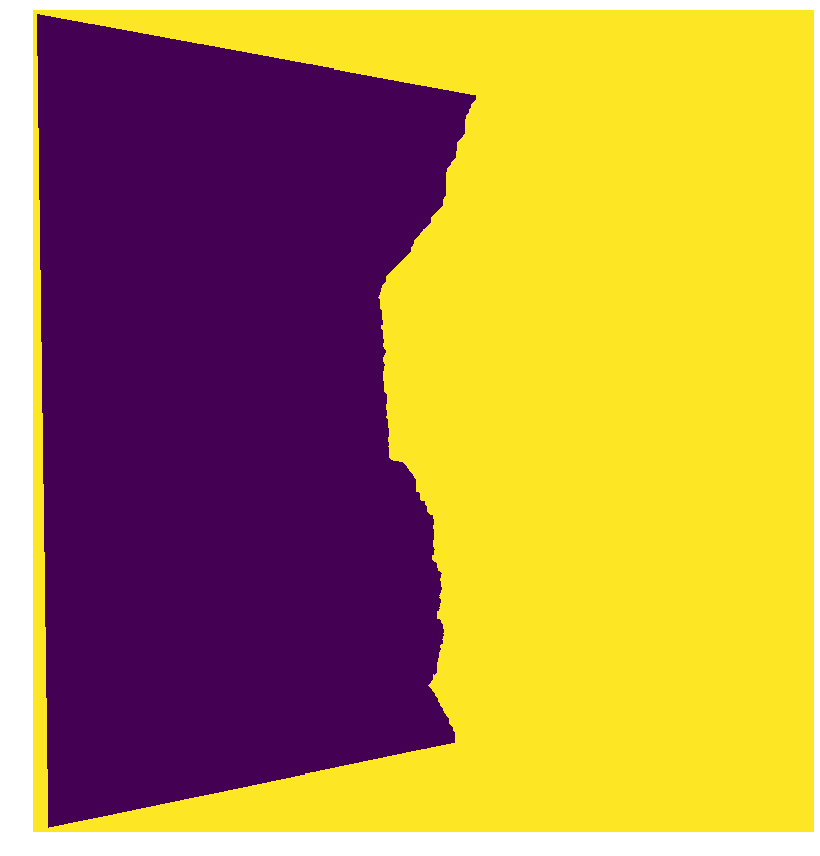

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(mask0, interpolation='none')

fig.tight_layout()
ax.axis('off');

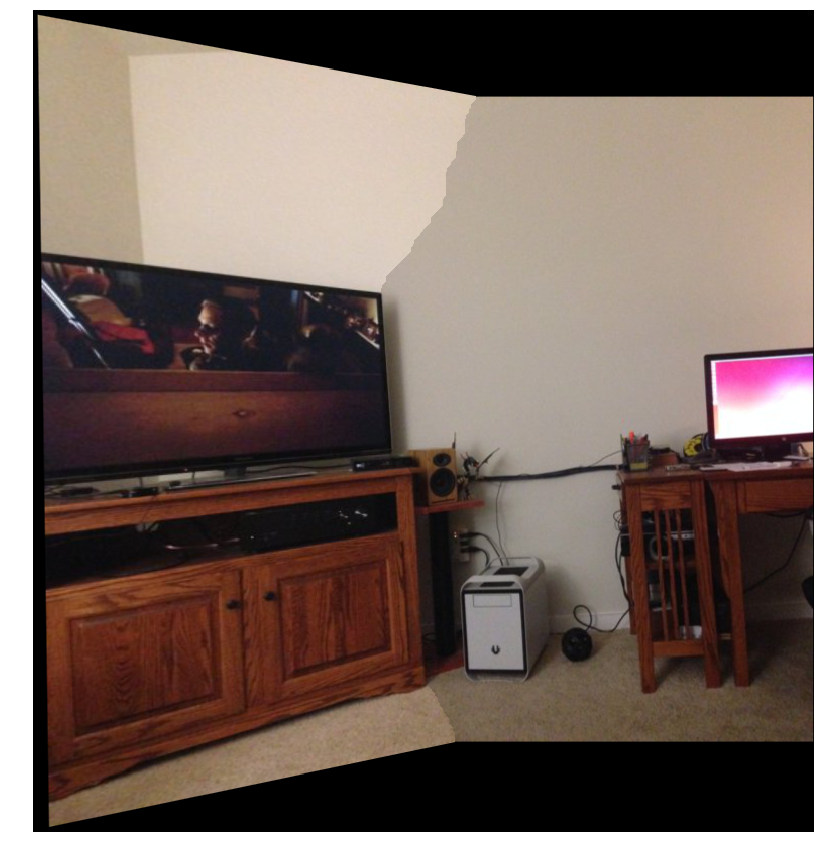

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(cv2.cvtColor(base_img_warp_,cv2.COLOR_BGR2RGB), interpolation='none')

fig.tight_layout()
ax.axis('off');

In [30]:
cv2.imwrite('merged_wthout_colour correction.jpg',base_img_warp_)

True

In [31]:
next_img_warp_hsv = cv2.cvtColor(next_img_warp, cv2.COLOR_BGR2HSV)
base_img_warp_hsv = cv2.cvtColor(base_img_warp, cv2.COLOR_BGR2HSV)

base_points_value = []
next_points_value = []

for i in range(roi.shape[0]):
    for j in range(roi.shape[1]):
        if roi[i,j]==255:
            base_points_value.append(base_img_warp_hsv[i,j,2])
            next_points_value.append(next_img_warp_hsv[i,j,2])
            
next_points_value = np.array(next_points_value).reshape(-1,1)
base_points_value = np.array(base_points_value).reshape(-1,1)

For colour correction we are learning linear transformation beetween colour space of overlapped region

we could do matching for all the three channels (but doing that individually changes color)

So we will change colour space to HSV and do intensitive correction 

for this we could use Ransac ,or linear regression

In [32]:
from sklearn import linear_model

model_ransac_value= linear_model.LinearRegression()
model_ransac_value.fit(next_points_value,base_points_value)

base_image_correction = linear_model.LinearRegression()
#base_image_correction.coef_ = 1/(np.sqrt(model_ransac_value.coef_))
base_image_correction.coef_ = np.array([1])
#base_image_correction.intercept_ = -1*(1/np.sqrt(model_ransac_value.coef_))*model_ransac_value.intercept_/2
base_image_correction.intercept_ = -1*model_ransac_value.intercept_/2

next_image_correction =linear_model.LinearRegression()
#next_image_correction.coef_ = np.sqrt(model_ransac_value.coef_)
next_image_correction.coef_ = model_ransac_value.coef_
#next_image_correction.intercept_ = (1/np.sqrt(model_ransac_value.coef_))*model_ransac_value.intercept_/2
next_image_correction.intercept_ = model_ransac_value.intercept_/2

In [33]:
next_img_warp_hsv[:,:,2] = np.uint8(np.clip(next_image_correction.predict(next_img_warp_hsv[:,:,2].reshape(-1,1)),0,255)).reshape(next_img_warp_hsv[:,:,2].shape)
base_img_warp_hsv[:,:,2] = np.uint8(np.clip(base_image_correction.predict(base_img_warp_hsv[:,:,2].reshape(-1,1)),0,255)).reshape(next_img_warp_hsv[:,:,2].shape)

In [34]:
next_img_warp_rgb = cv2.cvtColor(next_img_warp_hsv, cv2.COLOR_HSV2BGR)
base_img_warp_rgb = cv2.cvtColor(base_img_warp_hsv, cv2.COLOR_HSV2BGR)

In [35]:
cost = generate_costs_minimum_cut(np.abs(cv2.cvtColor(next_img_warp_rgb,cv2.COLOR_BGR2GRAY)-cv2.cvtColor(base_img_warp_rgb,cv2.COLOR_BGR2GRAY)),
                        roi/255)

In [36]:
for box in boundingboxes: 
    #mask0 = get_division_mask(cost, roi,mask_next/255, 0)
    mask0 = get_division_mask(cost, mask_base, mask_next,box, 0)

    pano_combined_1 = np.zeros_like(base_img_warp)

    # Place the masked portion of each image into the array
    # masks are 2d, they need to be (M, N, 3) to match the color images
    pano_combined_1 += base_img_warp_rgb * gray2rgb(mask0)
    pano_combined_1 += next_img_warp_rgb * gray2rgb(~mask0)

    base_img_warp_ = pano_combined_1

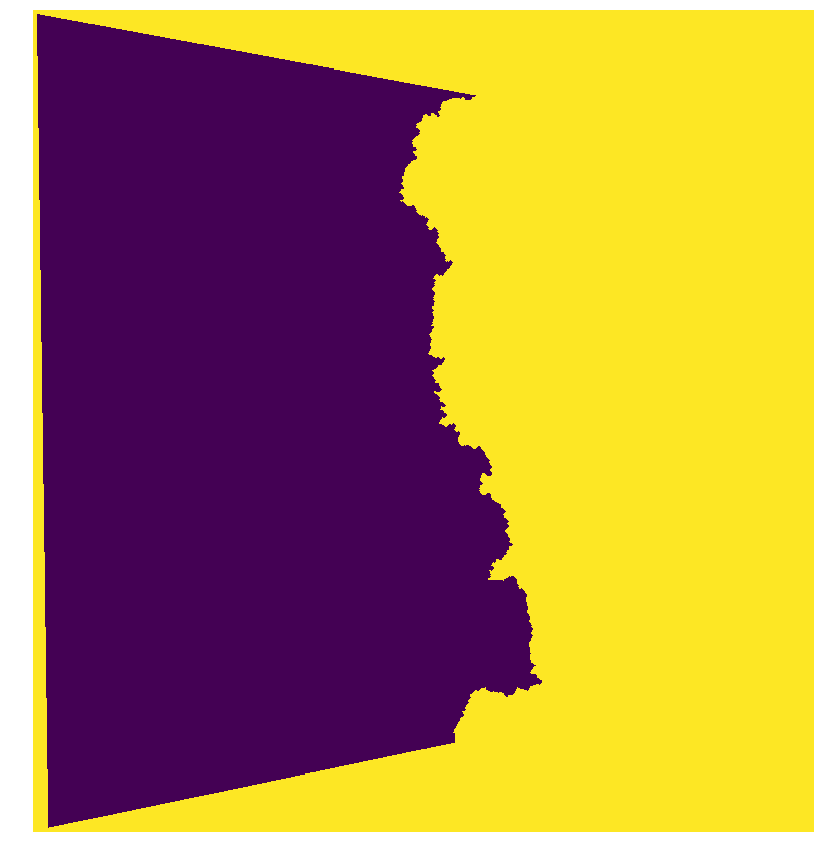

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(mask0, interpolation='none')

fig.tight_layout()
ax.axis('off');

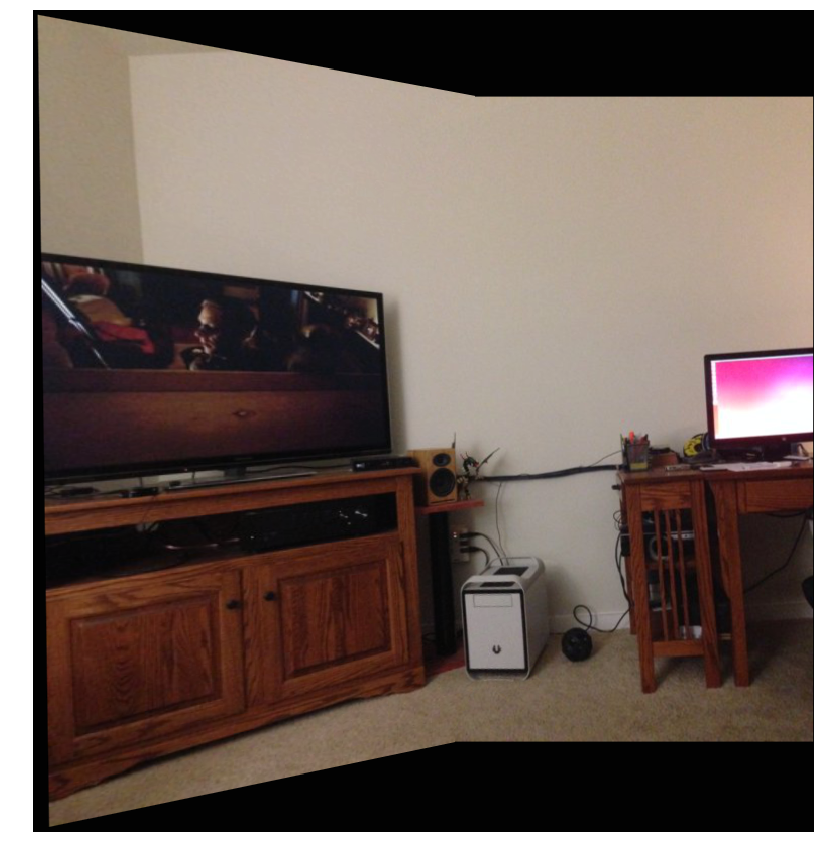

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(cv2.cvtColor(base_img_warp_,cv2.COLOR_BGR2RGB), interpolation='none')

fig.tight_layout()
ax.axis('off');